In [1]:
import numpy as np
import pylab as plt

# Mean Field Implementation of the Cortical Microcircuit
### Table of contents
* About this tutorial
* Mean field approximation
    * Fokker-Planck formalism
    * Parameters
    * Task 1 - Verify the equation for $K_{ij}$
    * Define neuron model
    * Define external inputs
    * Task 2 - Define connectivity (number of connections and synaptic efficacy
    * Task 3 - Perform numerical integration
    * Evaluate results
* References

## About this tutorial
The objective of this tutorial is to familiarize you with mean field approximations

## Mean field approximation
Potjans and Diesmann (2014) aggregated connectivity information of local circuits (cortical column) in early visual cortex. They subsequently used this information to simulate a network of $\sim 80000$ leaky integrate-and-fire (LIF) neurons arranged in four layers each with an excitatory and an inhibitory pool. That is quite a feat and simulation of this circuit has led to important insights. However, simulating such a system takes a very long time unless it is performed on a supercomputer. Let's see if we can simulate a mean field approximation of the column model.

<img src="Microcircuit.png"> <img src="Raster.png">

## Fokker-Planck formalism
Following Schuecker et al. (2016), the stationary firing rate $\nu_i$ of each population $i$ are given by

$\nu_i = \Phi[ \mu_i(t),\sigma_i(t)] = \{\tau_r + \tau_m \sqrt{\pi} \int_{\frac{V_{reset}-V_L-\mu_i(t)}{\sigma_i(t)} + \gamma \sqrt{\frac{\bar{\tau_s}}{\tau_m}}}^{\frac{\theta-V_L-\mu_i(t)}{\sigma_i(t)} + \gamma \sqrt{\frac{\bar{\tau_s}}{\tau_m}}} e^{x^2} (1 + erf(x))dx\}^{-1}$

where $\gamma = \frac{|\zeta(\frac{1}{2})|}{\sqrt{2}}$, with $\zeta$ denoting the Rieman zeta function and $erf(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2}dt$ is the error function. The mean drive $\mu_i(t)$ as well as the diffusive noise $\sigma_i^2(t)$ depend on recurrent and external inputs:

$$\mu_i(t) = \tau_m (\sum_j \hat{K}_{ij} w_{ij} \nu_j + K_{ext} w_{ext} \nu_{ext})$$

$$\sigma_i^2(t) = \tau_m (\sum_j \hat{K}_{ij} w_{ij}^2 \nu_j + K_{ext} w_{ext}^2 \nu_{ext})$$

where $\hat{K}_{ij}$ is the average number of synapses arriving at pool $i$ from pool $j$ and $w_{ij}$ is the corresponding synaptic efficacy. Note that both $\mu$ and $\sigma$ are in units of mV.

## Parameters
Neuron model parameters are summarized in the table below

<img src="Parameters.png">

The following table contains information on the local circuit

<img src="Network.png">

The connectivity is given in terms of probabilities that a neuron in the target population receives a synapse from the source population. The equation for this probability is given by

$$P_{ij} = 1 - (1 - \frac{1}{N^j N^i})^{K_{ij}}$$

where $K_{ij}$ is the number of synapses from population $j$ to population $i$ and $N^j$ and $N^i$ are the number of pre- and postsynaptic neurons, respectively. The number of synapses is correspondingly given by

$$K_{ij} = \frac{ln(1-P_{ij})}{ln(1 - \frac{1}{N^j N^i})}$$

## Task 1 - Verify the equation for $K_{ij}$ - (33 points)

Solve $P_{ij} = 1 - (1 - \frac{1}{N^j N^i})^{K_{ij}}$ for $K_{ij}$.

For convenience, we first define $b := 1 - \frac{1}{N^j N^i}$ such that $P_{ij} = 1 - (1 - \frac{1}{N^j N^i})^{K_{ij}} = 1 -b^{K_{ij}}$



$$
\begin{array}{ll}
&P_{ij} &= 1 - b^{K_{ij}} \\
&b^{K_{ij}} &= 1 - P_{ij} &\textrm{move the } P_{ij} \textrm{ term to the right and the term involving } K_{ij} \textrm{ to the left} \\
&K_{ij} &= \log_b \left( 1 - P_{ij} \right) &\textrm{take the logarithm to base } b \\
&K_{ij} &= \frac{ \ln \left( 1 - P_{ij} \right )}{\ln b} &\textrm{change of base to obtain an expression in terms of the natural logarithm (base is } e \textrm{)} \\
&K_{ij} &= \frac{ \ln \left( 1 - P_{ij} \right )}{\ln \left( 1 - \frac{1}{N^j N^i} \right)} &\textrm{replace } b \textrm{ with its definition}
\end{array}
$$

In [2]:
# Define neuron model
J = 87.8        # synaptic strength (pA)
g = -4          # relative inhibitory synaptic strength
tau_s = 0.5e-3  # postsynaptic current time constant (s)
tau_m = 10e-3   # membrane time constant (s)
tau_r = 2e-3    # refractory period
C_m = 250       # membrane capacitance (pF)
V_reset = -65   # reset potential (mV)
V_L = -65       # leak potential (mV)
theta = -50     # threshold potential (mV)

# Define external inputs
K_ext = np.array(   # number of external connections
    [1600, 1500, 2100, 1900, 2000, 1900, 2900, 2100])

nu_ext = 8  # firing rate per connection (Hz)

## Task 2 - Define connectivity (number of connections $K$ and synaptic efficacy $W$ - 33 points)
Note that synaptic strength and synaptic efficacy are not the same. You will need to calculate $W$ bassed on other information you have. You also need to calculate the number of connections $K_{ij}$ between pools $i$ and $j$. Importantly, we are interested in the total number of connections received by pool $i$ from pool $j$, not in the number of connections received per neuron in pool $i$!

In [3]:
N = np.array(    # number of neurons
    [20683, 5834, 21915, 5479, 4850, 1065, 14395, 2948])
P = np.array(   # connection probability
    [[0.1010, 0.1690, 0.0440, 0.0820, 0.0320, 0.0000, 0.0080, 0.0000],
    [ 0.1350, 0.1370, 0.0320, 0.0520, 0.0750, 0.0000, 0.0040, 0.0000],
    [ 0.0080, 0.0060, 0.0500, 0.1350, 0.0070, 0.0003, 0.0450, 0.0000],
    [ 0.0690, 0.0030, 0.0790, 0.1600, 0.0030, 0.0000, 0.1060, 0.0000],
    [ 0.1000, 0.0620, 0.0510, 0.0060, 0.0830, 0.3730, 0.0200, 0.0000],
    [ 0.0550, 0.0270, 0.0260, 0.0020, 0.0600, 0.3160, 0.0090, 0.0000],
    [ 0.0160, 0.0070, 0.0210, 0.0170, 0.0570, 0.0200, 0.0400, 0.2250],
    [ 0.0360, 0.0010, 0.0030, 0.0010, 0.0280, 0.0080, 0.0660, 0.1440]]).transpose()

K_hat = (np.log(1 - P) / np.log(1 - 1 / np.outer(N,N)) / N).transpose()


W_exc = tau_s / C_m * J * 1e3 # mV
W_inh = W_exc * g # mV

W_ext = W_exc                        # external input (excitatory)
W_rec = np.tile([W_exc,W_inh],[8,4]) # recurrent synaptic connectivity matrix

## Task 3 - Perform numererical integration - 33 points
We can now finally find the stationary firing rates of all interacting pools by numerically integrating $\dot{\nu}_i = -\nu_i + \Phi[ \mu_i(t), \sigma_i(t) ]$. You can use the forward Euler method with a timestep $\Delta t = 0.001$ to do so. Make sure to simulate sufficiently many time steps for the system to reach equilibrium ($\sim 5000$ should do the trick). You do not need to define the activation function $\Phi$, it comes with the materials for this tutorial (phi.py).

In [4]:
from phi import phi

dt      = 1e-3
t_steps = 5000

nu = np.zeros((8,t_steps))

for t in range(1, t_steps):
    mu    = (np.matmul(K_hat * W_rec, nu[:,t-1]) + K_ext*W_ext*nu_ext) * tau_m
    sigma = np.sqrt((np.matmul(K_hat * W_rec**2, nu[:,t-1]) + K_ext * W_ext**2 * nu_ext) * tau_m)
    nu[:,t] = nu[:,t-1] + dt * (-nu[:,t-1] + phi(mu, sigma))

## Evaluate results
As a last step, we need to check if the mean firing rates we obtained using the mean field approximation look anything like the results Potjans & Diesmann (2014) obtained when simulating their full model. Assuming that you called the firing rate variable keeping track of the firing rates $\nu$ and that pools are along its rows and time along its columns, the following code plots bar graphs showing the firing rate in all pools.

Compare this to the mean firing rates observed by Potjans & Diesmann (2014)

<img src="Rates.png">

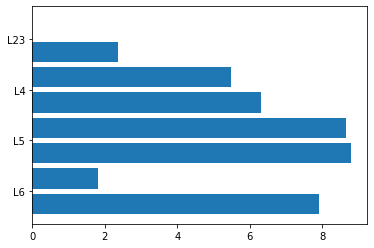

In [11]:
plt.figure()
plt.barh(width=nu[:,-1], y=np.arange(8))
plt.yticks([0.5, 2.5, 4.5, 6.5], labels=['L23', 'L4', 'L5', 'L6'])
plt.gca().invert_yaxis()
plt.show()

## References
* Potjans TC, Diesmann M. The cell-type specific cortical microcircuit: relating structure and activity in a full-scale spiking network model. Cereb Cortex. 2014 Mar;24(3):785-806. doi: 10.1093/cercor/bhs358. Epub 2012 Dec 2. PMID: 23203991; PMCID: PMC3920768
* Schuecker, J., Schmidt, M., van Albada, S. J., Diesmann, M., & Helias, M. (2017). Fundamental Activity Constraints Lead to Specific Interpretations of the Connectome. PLOS Computational Biology, 13(2), e1005179. https://doi.org/10.1371/journal.pcbi.1005179